https://www.kaggle.com/c/titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
from pandas import Series
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("seaborn version: {}".format(sns.__version__))
print("missingno version: {}".format(msno.__version__))
import time
#import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
#print("lightgbm version: {}".format(lightgbm.__version__))
#print("sklearn version: {}".format(sklearn.__version__))
import warnings

pandas version: 0.23.0
numpy version: 1.14.5
matplotlib version: 2.2.2
seaborn version: 0.8.1
missingno version: 0.4.1


In [2]:
plt.style.use('seaborn')
#https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
sns.set(font_scale = 2.5)
warnings.filterwarnings('ignore')
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
! pwd

/Users/dohyung/SourceTree/dohyung/2.study/kaggle_study


In [4]:
df_train = pd.read_csv("./dataset/_kaggle_01_titanic/train.csv")
df_test = pd.read_csv("./dataset/_kaggle_01_titanic/test.csv")
# df_train = pd.read_csv('../input/train.csv')
# df_test = pd.read_csv('../input/test.csv')

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### feature 마다의 특성
- Pclass: first class, ..: categorical & order
- Survived: target label
- Sex: binary
- Age: continuous
- Ticket: Text
- Embarked: categorical & non-order

In [6]:
print(df_train.shape)
print(df_train.describe())
'''각 feature에 대한 통계적 결과'''

(891, 12)
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


'각 feature에 대한 통계적 결과'

- df_train.describe()의 결과 Age feature의 경우 사람마다 반드시 가져야만 하는 값인데, df_train.shape의 결과로 나온 승객의 수(891)와 count(714)가 일치하지 않는 모습이 보인다 -> null 데이터가 존재하고 있음을 알 수 있다.(해당 feature에 null 데이터가 존재함을 의미하며, 모든 feature에 null 데이터가 존재하는지를 알아보기 위해서는 별도의 처리가 필요하다.)

In [7]:
print(df_train.max())

PassengerId                            891
Survived                                 1
Pclass                                   3
Name           van Melkebeke, Mr. Philemon
Sex                                   male
Age                                     80
SibSp                                    8
Parch                                    6
Ticket                           WE/P 5735
Fare                               512.329
dtype: object


In [8]:
print(df_test.describe())

       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200


In [9]:
print(df_train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [10]:
# null 데이터 비율
for col in df_train.columns:
    msg = 'column : {:>10}\t Percent of NaN value: {:.2f}%'\
                            .format(col, 
                                    100*(df_train[col].isnull().sum()) / df_train[col].shape[0]) # '>':정렬
    print(msg)

column : PassengerId	 Percent of NaN value: 0.00%
column :   Survived	 Percent of NaN value: 0.00%
column :     Pclass	 Percent of NaN value: 0.00%
column :       Name	 Percent of NaN value: 0.00%
column :        Sex	 Percent of NaN value: 0.00%
column :        Age	 Percent of NaN value: 19.87%
column :      SibSp	 Percent of NaN value: 0.00%
column :      Parch	 Percent of NaN value: 0.00%
column :     Ticket	 Percent of NaN value: 0.00%
column :       Fare	 Percent of NaN value: 0.00%
column :      Cabin	 Percent of NaN value: 77.10%
column :   Embarked	 Percent of NaN value: 0.22%


In [11]:
print(col)
print(type(df_train[col]))
print(df_train[col])

Embarked
<class 'pandas.core.series.Series'>
0      S
1      C
2      S
3      S
4      S
5      Q
6      S
7      S
8      S
9      C
10     S
11     S
12     S
13     S
14     S
15     S
16     Q
17     S
18     S
19     C
20     S
21     S
22     Q
23     S
24     S
25     S
26     C
27     S
28     Q
29     S
      ..
861    S
862    S
863    S
864    S
865    S
866    C
867    S
868    S
869    S
870    S
871    S
872    S
873    S
874    C
875    C
876    S
877    S
878    S
879    C
880    S
881    S
882    S
883    S
884    S
885    Q
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object


In [12]:
print(df_train[col].isnull())

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
861    False
862    False
863    False
864    False
865    False
866    False
867    False
868    False
869    False
870    False
871    False
872    False
873    False
874    False
875    False
876    False
877    False
878    False
879    False
880    False
881    False
882    False
883    False
884    False
885    False
886    False
887    False
888    False
889    False
890    False
Name: Embarked, Length: 891, dtype: bool


In [13]:
print(df_train[col].isnull().sum()) # null 데이터의 개수
# True == 1

2


In [14]:
print(df_train[col].isnull().sum() / df_train.shape[0]) # null 데이터의 전체 대비 비율

0.002244668911335578


In [15]:
# ESC + F : find & replace

In [16]:
# null 데이터 비율
for col in df_test.columns:
    msg = 'column : {:>10}\t Percent of NaN value: {:.2f}%'\
                            .format(col, 
                                    100*(df_test[col].isnull().sum()) / df_test[col].shape[0]) # '>':정렬
    print(msg)

column : PassengerId	 Percent of NaN value: 0.00%
column :     Pclass	 Percent of NaN value: 0.00%
column :       Name	 Percent of NaN value: 0.00%
column :        Sex	 Percent of NaN value: 0.00%
column :        Age	 Percent of NaN value: 20.57%
column :      SibSp	 Percent of NaN value: 0.00%
column :      Parch	 Percent of NaN value: 0.00%
column :     Ticket	 Percent of NaN value: 0.00%
column :       Fare	 Percent of NaN value: 0.24%
column :      Cabin	 Percent of NaN value: 78.23%
column :   Embarked	 Percent of NaN value: 0.00%


In [17]:
# null 데이터를 꼭 채운다고 성능이 높아진다는 보장은 없다

'iloc:index location;원하는 위치의 데이터를 가져온다. msno.matrix();데이터의 위치를 가져와서 그 분포를 그려준다. null 데이터의 경우 비어있게 된다.'

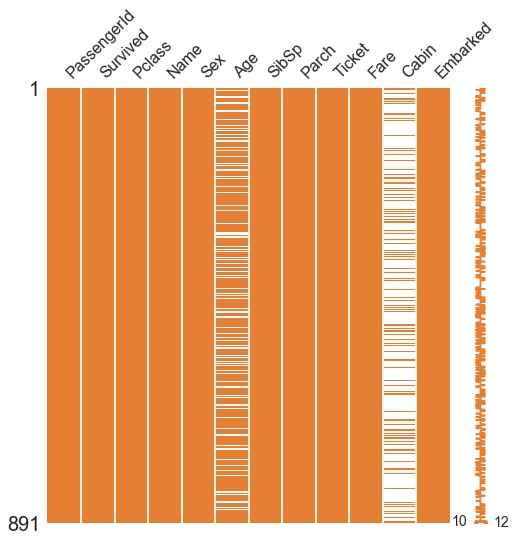

In [18]:
msno.matrix(df=df_train.iloc[:,:], figsize=(8,8), color=(0.9, 0.5, 0.2)) # color = (R, G, B)
'''iloc:index location;원하는 위치의 데이터를 가져온다. msno.matrix();데이터의 위치를 가져와서 그 분포를 그려준다. null 데이터의 경우 비어있게 된다.'''

'iloc:index location;원하는 위치의 데이터를 가져온다. msno.bar();데이터를 가져와서 그 횟수를 알려준다.'

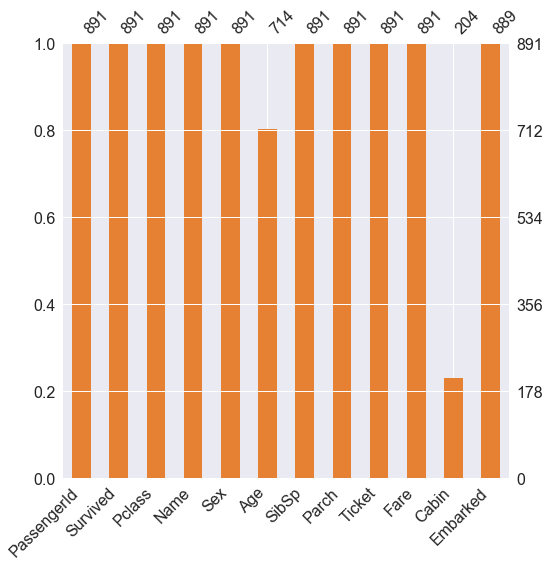

In [19]:
msno.bar(df=df_train.iloc[:,:], figsize=(8,8), color=(0.9, 0.5, 0.2)) # color = (R, G, B)
'''iloc:index location;원하는 위치의 데이터를 가져온다. msno.bar();데이터를 가져와서 그 횟수를 알려준다.'''

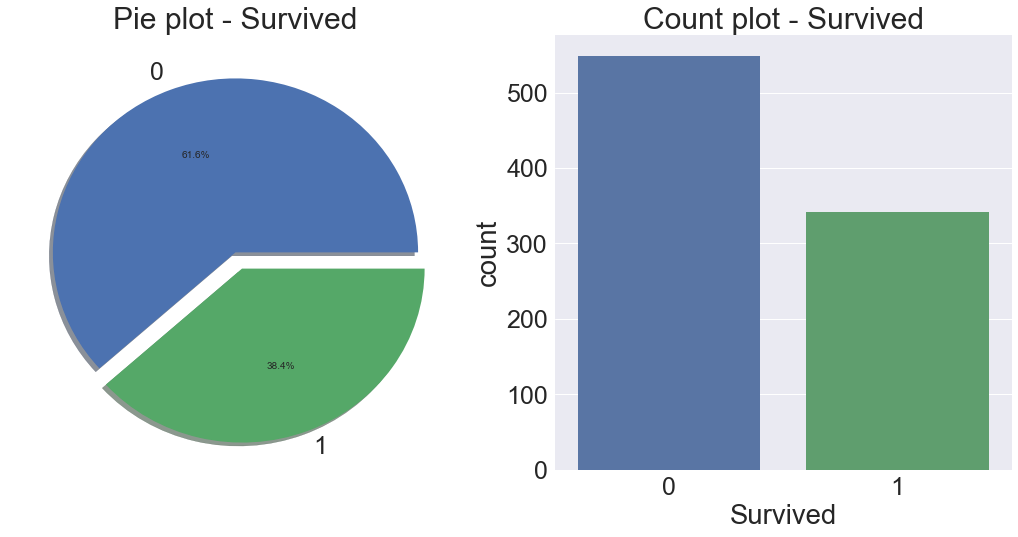

In [62]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

In [20]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

In [21]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,2.135148,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3.948596,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,3.048088,NaN,S,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,2.409941,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,3.403555,NaN,C,2


In [22]:
df_train['Initial']=0
for i in df_train:
    df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']=0
for i in df_test:
    df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [23]:
pd.crosstab(df_train['Initial'], 
            df_train['Sex']).T.style.background_gradient(cmap='summer_r')#Checking the Initials with the Sex


Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [24]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)


In [25]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


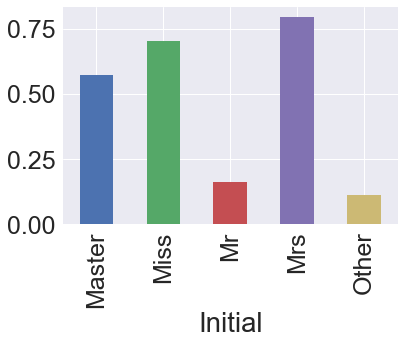

In [26]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [27]:
df_all = pd.concat([df_train, df_test])

In [28]:
df_all.groupby('Initial').mean()

,Age,FamilySize,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Initial,,,,,,,,
Master,5.482642,4.426230,3.262225,1.377049,658.852459,2.655738,2.049180,0.575000
Miss,21.834533,2.147170,3.065227,0.494340,616.992453,2.332075,0.652830,0.704301
Mr,32.556397,1.446174,2.680701,0.159533,658.831388,2.359274,0.286641,0.162571
Mrs,37.034884,2.482412,3.488188,0.824121,685.673367,1.929648,0.658291,0.795276
Other,44.923077,1.384615,2.951897,0.153846,714.923077,1.615385,0.230769,0.111111


In [29]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=37
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=45

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=37
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=45

In [30]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')


Embarked has  2  Null values


In [31]:
df_train['Embarked'].fillna('S', inplace=True)


In [32]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [33]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [34]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())


1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [35]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

In [36]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})


In [37]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [38]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [39]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})


In [40]:
df_train['Embarked'].isnull().any()

False

In [42]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})


In [43]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,2,3
5,6,0,3,"Moran, Mr. James",1,0,0,330877,2.135148,NaN,1,1,2,3
6,7,0,1,"McCarthy, Mr. Timothy J",1,0,0,17463,3.948596,E46,2,1,2,5
7,8,0,3,"Palsson, Master. Gosta Leonard",1,3,1,349909,3.048088,NaN,2,5,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,0,2,347742,2.409941,NaN,2,3,3,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,1,0,237736,3.403555,NaN,0,2,3,1


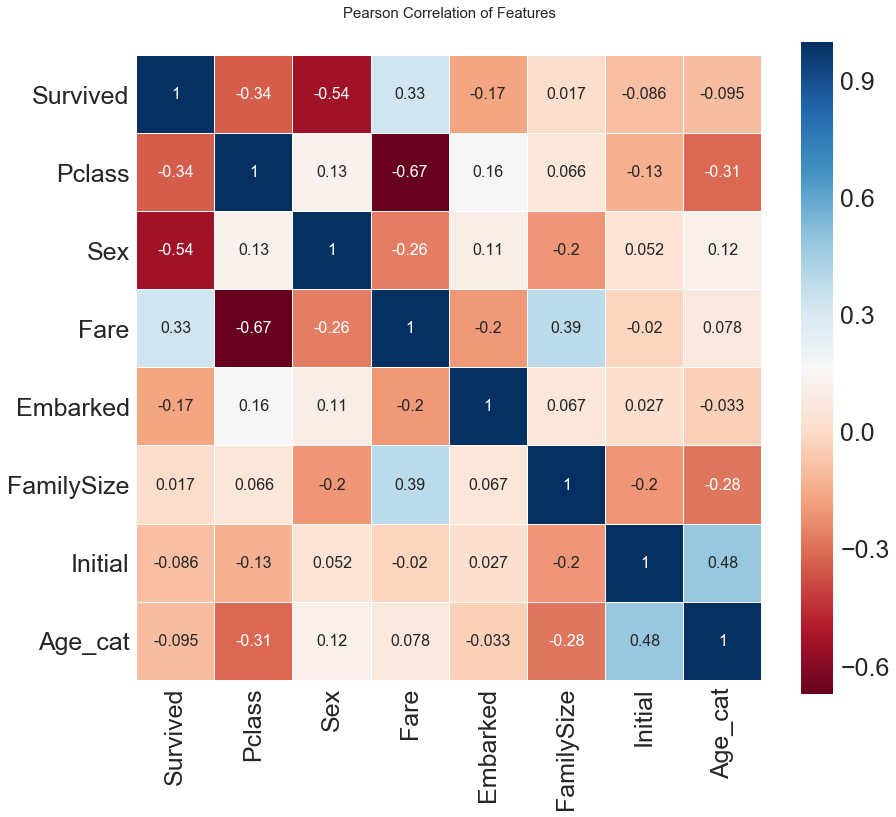

In [44]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data


In [45]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')


In [46]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0
5,6,0,3,"Moran, Mr. James",1,0,0,330877,2.135148,NaN,1,1,3,0,0,1,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",1,0,0,17463,3.948596,E46,2,1,5,0,0,1,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",1,3,1,349909,3.048088,NaN,2,5,0,1,0,0,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,0,2,347742,2.409941,NaN,2,3,2,0,0,0,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,1,0,237736,3.403555,NaN,0,2,1,0,0,0,1,0


In [47]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [48]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [49]:
df_train

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1
5,0,3,1,2.135148,1,3,0,0,1,0,0,0,1,0
6,0,1,1,3.948596,1,5,0,0,1,0,0,0,0,1
7,0,3,1,3.048088,5,0,1,0,0,0,0,0,0,1
8,1,3,0,2.409941,3,2,0,0,0,1,0,0,0,1
9,1,2,0,3.403555,2,1,0,0,0,1,0,1,0,0


In [50]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

In [51]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [52]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)


In [53]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [54]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.21% 정확도로 생존을 맞춤


In [55]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)


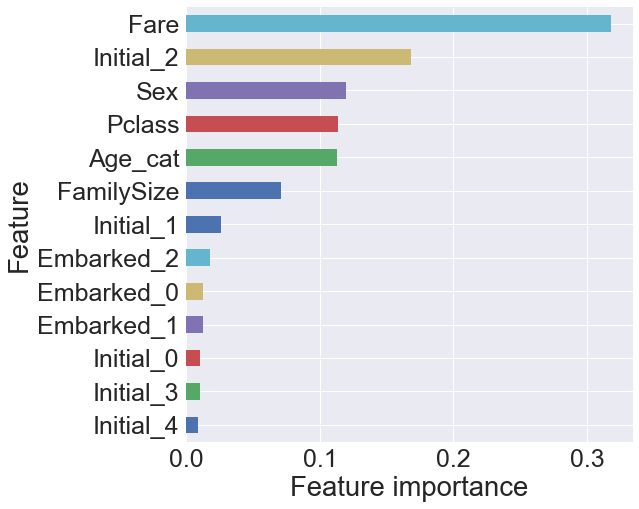

In [56]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [58]:
submission = pd.read_csv('./dataset/_kaggle_01_titanic/gender_submission.csv')

In [59]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [60]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [61]:
submission.to_csv('./result/_kaggle_01_titanic/my_first_submission.csv', index=False)